***IMPORTANTO LIBRERIAS***

In [18]:

import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import os
import keras
import numpy as np
from tensorflow.keras import models, layers
import tensorflow_hub as hub
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

GPU is NOT AVAILABLE


In [3]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)

data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')



def count(dir, counter=0):
    "num archivos"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + " arc"

print('img entrenamiento :', count(train_dir))
print('img validacion :', count(validation_dir))


img entrenamiento : C:\Users\Natho\.keras\datasets\PlantVillage\train : 43444 arc
img validacion : C:\Users\Natho\.keras\datasets\PlantVillage\validation : 10861 arc


**CONSTANTES Y DATASET**


In [4]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
dataset2 = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 43444 files belonging to 38 classes.
Found 10861 files belonging to 38 classes.


TIPO CLASIFICACION

In [4]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [9]:
len(dataset)


679

In [10]:

len(dataset2)

170

PREPROCESAMIENTO

In [11]:

train_ds = dataset.take(679)

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



len(train_ds)



679

In [14]:
val_ds = dataset2.take(170)

len(val_ds)

170

ESTRUCTURA DEL MODELO

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 38

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (64, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 60, 60, 64)         

OPTIMIZADOR y COMPILADOR


In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

ENTRENANDO

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
  2/679 [..............................] - ETA: 43:26 - loss: 0.3586 - accuracy: 0.9141

KeyboardInterrupt: 

EVALUANDO

In [17]:
scores = model.evaluate(val_ds)

170/170 [==============================] - 143s 841ms/step - loss: 0.2085 - accuracy: 0.9336


PROBANDO

primera imagen a predecir
real: Cherry_(including_sour)___healthy
2/2 [==============================] - 1s 385ms/step
predicción: Cherry_(including_sour)___healthy
1/1 [==============================] - 0s 28ms/step


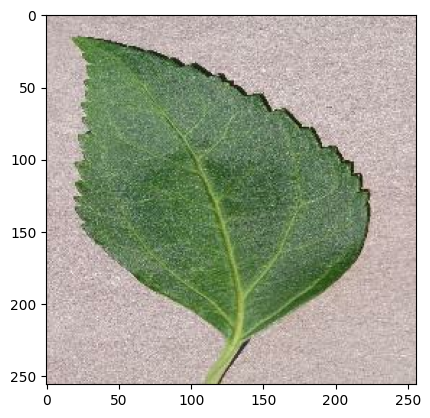

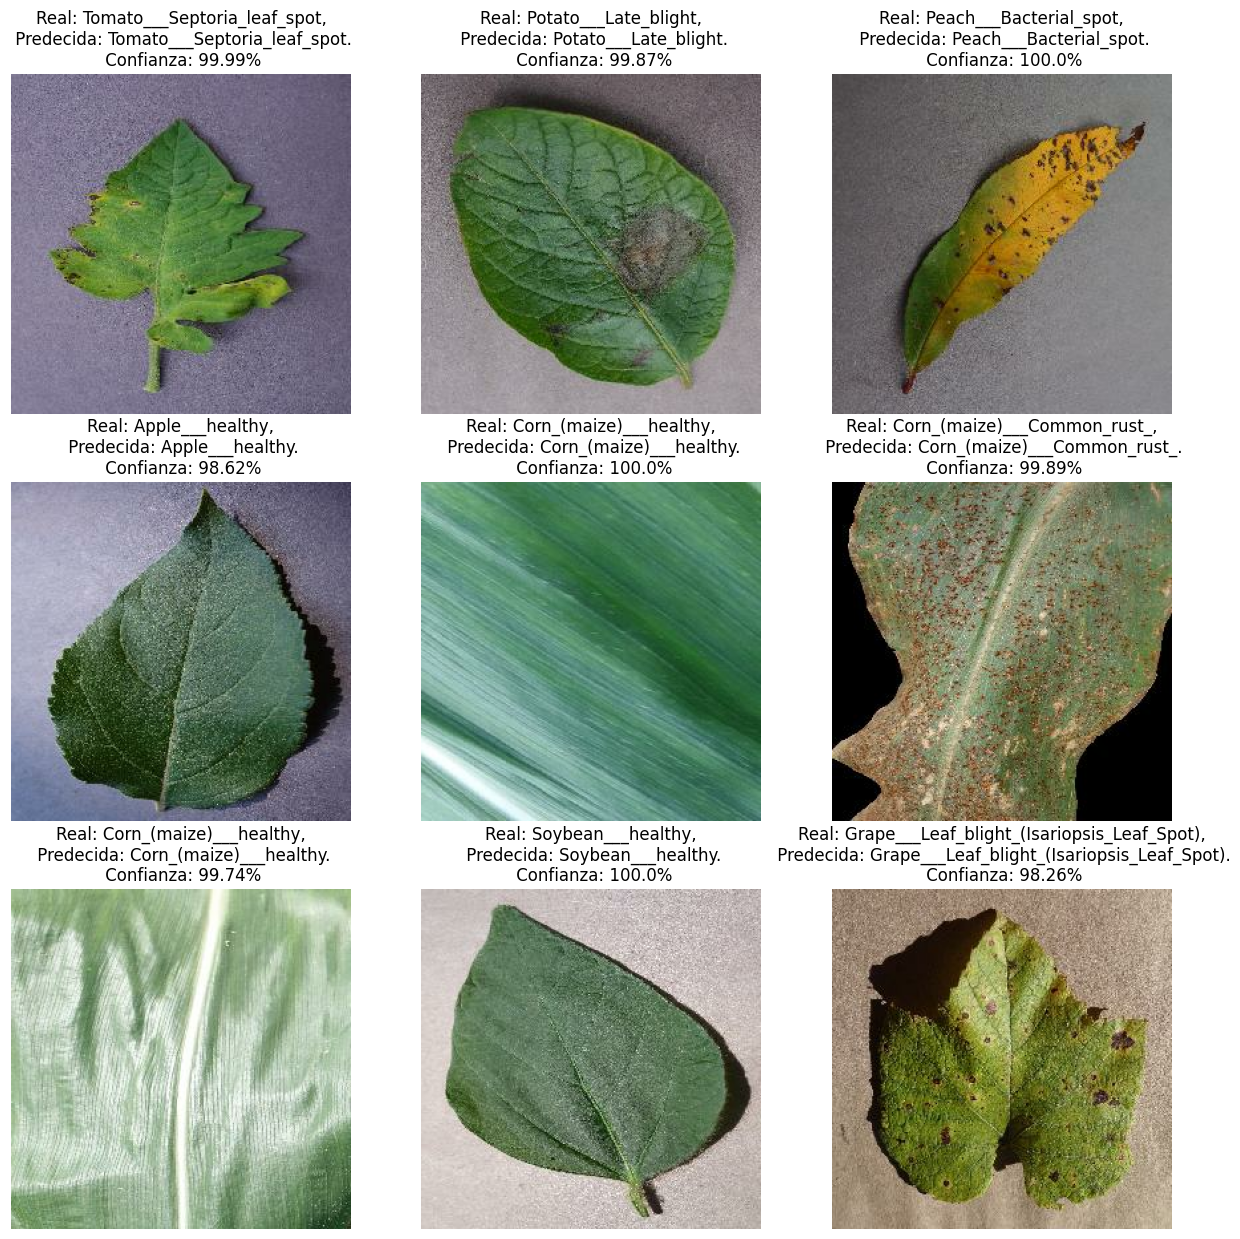

In [29]:
import numpy as np
for images_batch, labels_batch in val_ds.take(3):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("primera imagen a predecir")
    plt.imshow(first_image)
    print("real:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicción:",class_names[np.argmax(batch_prediction[0])])

    def predict(model, img):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)

        predicted_class = class_names[np.argmax(predictions[0])]
        confidence = round(100 * (np.max(predictions[0])), 2)
        return predicted_class, confidence

    plt.figure(figsize=(15, 15))
    for images, labels in val_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
        
            predicted_class, confidence = predict(model, images[i].numpy())
            actual_class = class_names[labels[i]] 
        
            plt.title(f"Real: {actual_class},\n Predecida: {predicted_class}.\n Confianza: {confidence}%")
        
            plt.axis("off")
        break

**GUARDANDO EL MODELO

In [23]:
model.save("../plantas.h5")

**TESTEANDO NUEVAMENTE

In [6]:
recovered = keras.models.load_model('../plantas.h5')
scores = recovered.evaluate(val_ds)

NameError: name 'val_ds' is not defined

CONVIRTIENDO A TFLITE

In [11]:
recovered = keras.models.load_model('../plantas.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(recovered)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

open("plantas.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Natho\AppData\Local\Temp\tmp3ofnis84\assets


INFO:tensorflow:Assets written to: C:\Users\Natho\AppData\Local\Temp\tmp3ofnis84\assets


200856

In [12]:
input_details

[{'name': 'serving_default_sequential_input:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3]),
  'shape_signature': array([ -1, 256, 256,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [13]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 35,
  'shape': array([ 1, 38]),
  'shape_signature': array([-1, 38]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [21]:
recovered = keras.models.load_model('../plantas.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(recovered)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
val_ds.take(1)
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
predicted_labels = []
actual_labels = []

for image, label in val_ds.unbatch():
    interpreter.set_tensor(input_index, [image])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(label.numpy())

INFO:tensorflow:Assets written to: C:\Users\Natho\AppData\Local\Temp\tmp22mxucy7\assets


INFO:tensorflow:Assets written to: C:\Users\Natho\AppData\Local\Temp\tmp22mxucy7\assets


KeyboardInterrupt: 

In [22]:
predicted_labels[:10]

[24, 24, 24, 24, 32, 3, 8, 24, 19, 13]

In [23]:

actual_labels[:10]

[24, 24, 24, 24, 32, 3, 8, 24, 19, 32]